# **Weight Uncertainty in Neural Networks** - **Bayes by Backprop**
---
Seminar *Neue Entwicklungen im Deep Learning* | WiSe 20/21 | Sedat Koca, Glenn Dittmann

## Imports and PIP Intalls

In [ ]:
!pip install mxnet

In [ ]:
from tqdm import tqdm
from __future__ import print_function
import collections

from matplotlib import pyplot as plt
from matplotlib.pylab import imshow
%matplotlib inline
import seaborn as sns
import numpy as np

import mxnet as mx
from mxnet import nd, autograd
ctx = mx.cpu() # setting the context on cpu

## **Introduction**
--- 

In this notebook, we present the algorithm *Bayes by Backprop*, which is an efficient and backpropagation compatible algorithm for learning a probability distribution on the weights of a neural network. This algorithm regularizes the weights by minimizing the compression cost. This functionality is also known as the expected lower bound of the marginal likelihood. This type of regularization performs comparably to dropout in MNIST classification. The learned uncertainty in the weights can be used to improve generalization in non-linear regression problems. Furthermore, this uncertainty in weights can be used to guide the trade-off between exploration and exploitation in reinforcement learning.


Deep neural networks are widely used for classification and regression tasks. In this context deep or simple neural networks are prone to overfitting, because they take irrelevant or less relevant features into the decision process and overweight them. The problem here is that predicted values results in a high deviation from the actual values if not all expected features match.


For such problems, several methods have been developed. For example, to prevent the overfitting problem in neural networks stopping training early, weight loss or dropout can help. In case of dropout, a certain percentage of (random) weights is disabled during training.

The authors of paper [1] suggest three motivations for introducing uncertainty in the weights. These are:

1.   regularization through compression costs for the weights,
2.   richer representations and predictions through cheap model averaging, and
3.   exploration in simple reinforcement learning problems such as contextual bandits.


Furthermore, the authors of [1] present an efficient, principled algorithm for regularization that is based on Bayesian inference on the weights of the network, which, in this case, results in a simple approximate learning algorithm which can be easily be incorporated into the usually backpropagation for wieght updating.






---



A classical architecture of a multi layer preceptron (MLP) without bias terms is shown below in Figure 1. The weights in this network have a fixed value. In comparison, Figure 2 shows a neural network where the weights are represented by a probability distribution over all possible values.

The learned representations and computations must be robust to deviations in the weights. This is because the measure of deviation that each weight has is learned in a way that coherently explains the variability in the training data. 

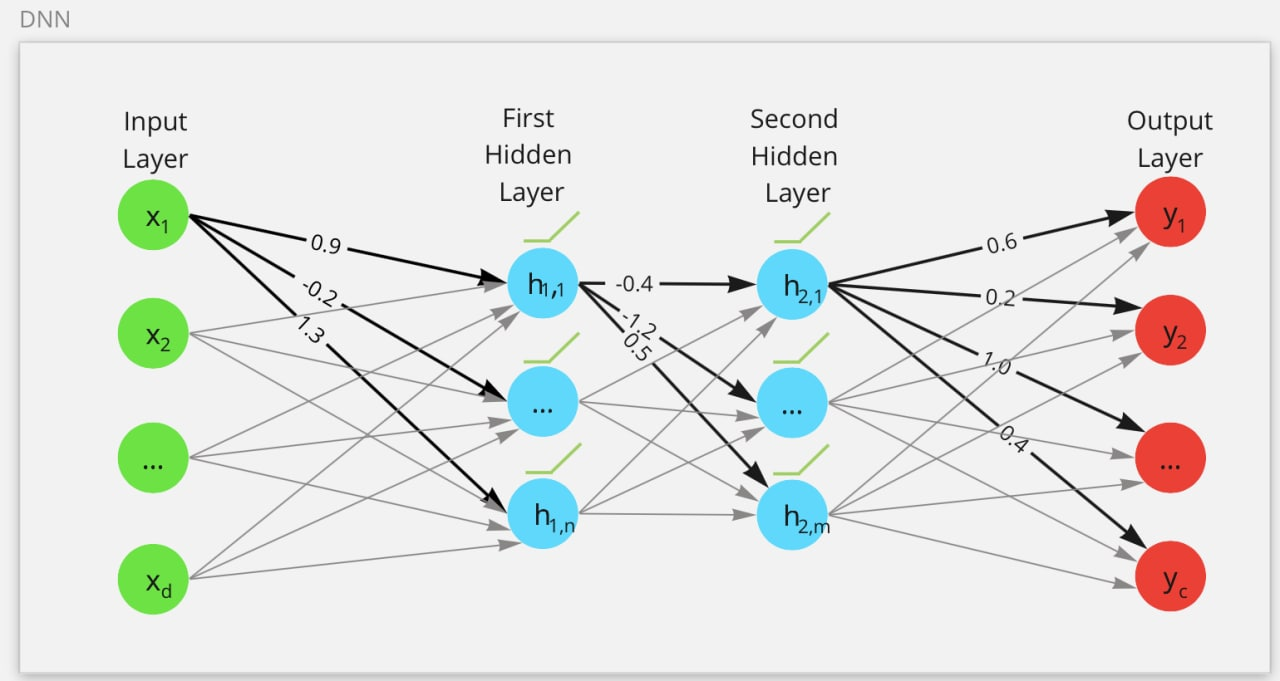 Figure 1: Each weight has a fixed value, as provided by classical backpropagation.

The usual goal of training a neural network is to find an optimal point estimate for the weights. While networks trained with this approach usually perform well in regions with a large amount of data, they cannot correctly represent uncertainty in regions with little or no data, which leads to incorrect and onverly confident decisions. Because of this disadvantage, Bayesian learning is applied to neural networks, introducing probability distributions over the weights. In order to have an intuitive understanding of the probability distributions at each weight, the Gaussian distribution is used.

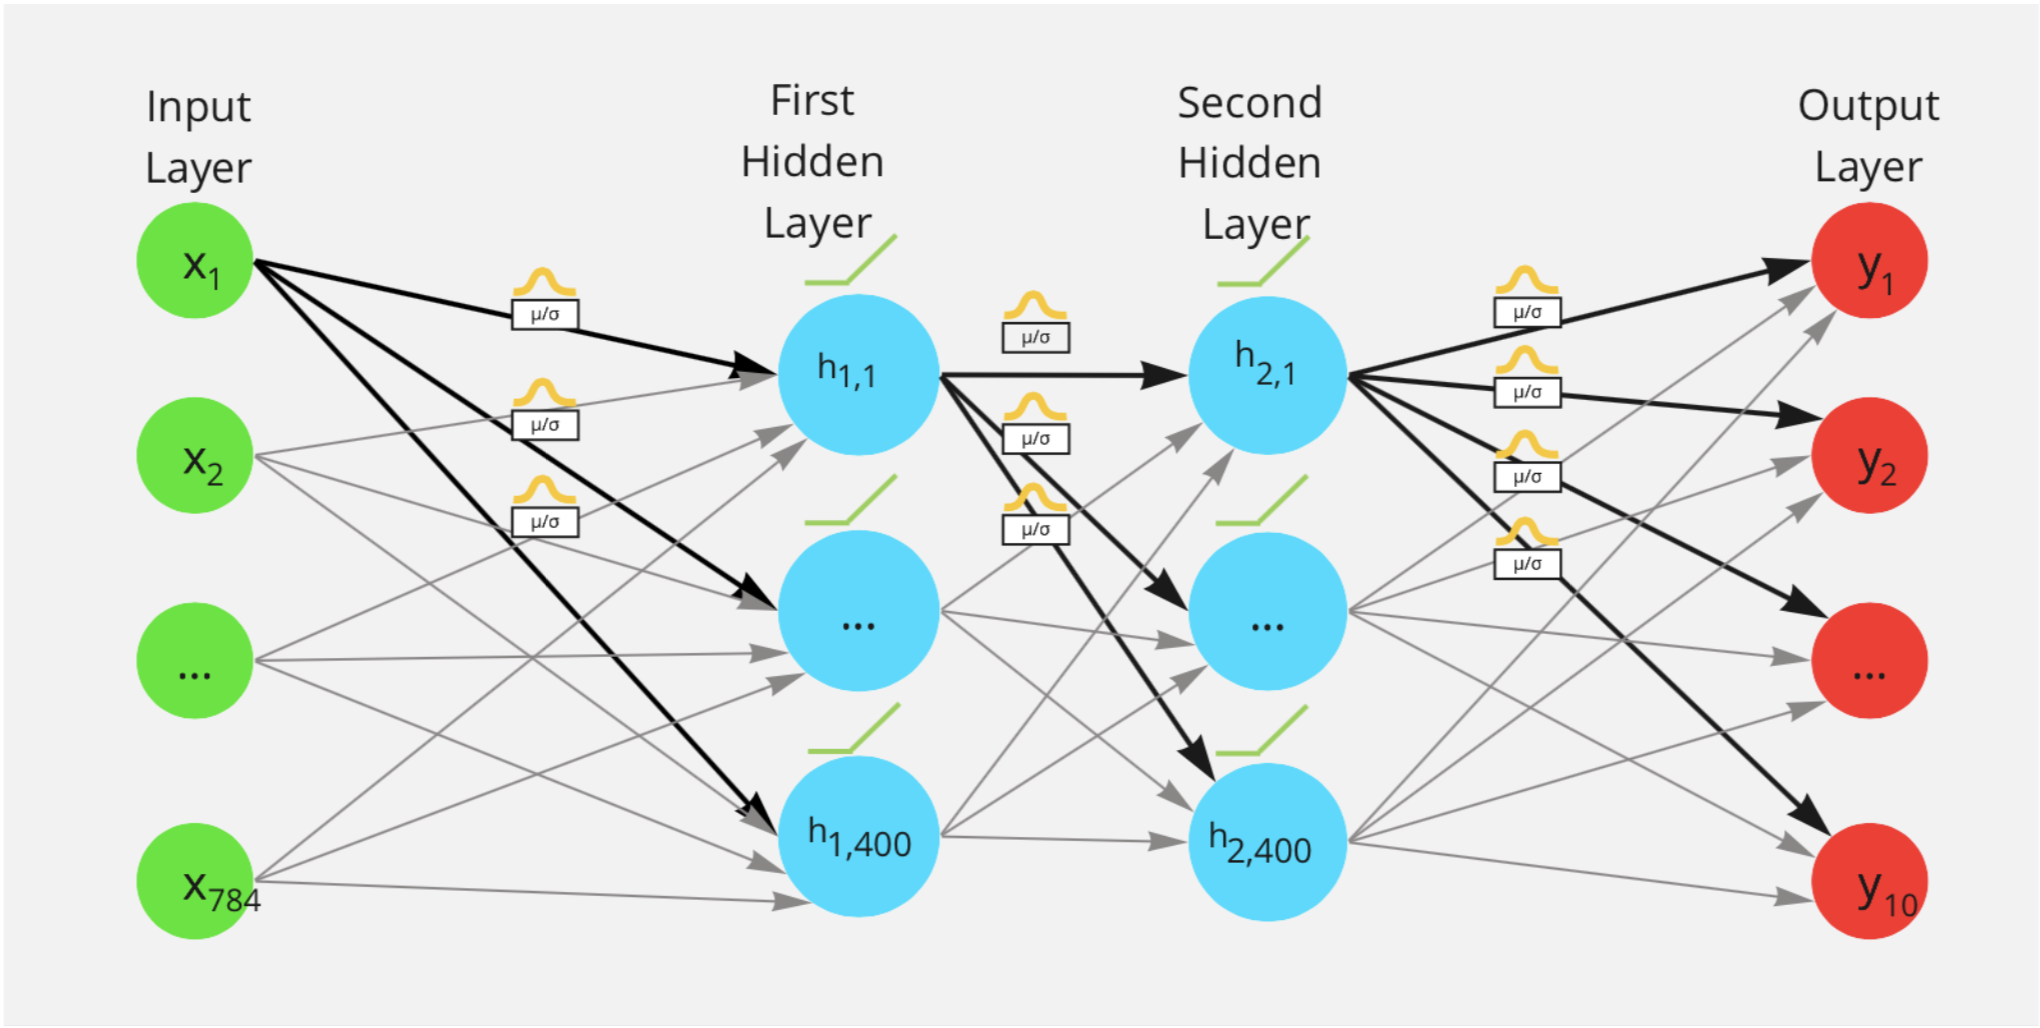
 Figure 2: each weight is assigned a distribution, as provided by Bayes by Backprop.

The problem is that an exact Bayesian inference on the parameters of a neural network is difficult to realize. The algorithm Bayes by Backprop is a great way to solve this problem by deriving a variational approximation for the true posterior. 

This algorithm will not only make the networks more "real" in terms of their overall uncertainty, but also perform regularization automatically, which eliminates the need to use dropouts in this model.

## Experimental parameter configuration 

To simplify the settings and experiments, let's define a directory that contains the hyper-parameters of our model

In [ ]:
# Note: in the paper the learning rate was denoted by alpha (chosen from 0.001, 0.0001 and 0.00001).
experiments_config = {
  "num_hidden_layers": 2,
   "num_hidden_units": 400,
         "batch_size": 128,
             "epochs": 100,
         "max_epochs": 600,
              "alpha": 0.001,
        "num_samples": 1,
                 "pi": 0.25,
        "sigma_prior": 1.0,
           "mu_prior": 0.0,
           "sigma_p1": 0.75,
           "sigma_p2": 0.1,
   "pixel_preprocess": 126.0
}

## Loading Dataset(s)

In [ ]:
def transform(data, label):
  # NOTE: in the original paper the pixel values were divided by 126, so it is done here as well for close reproducability
  return data.astype(np.float32)/experiments_config["pixel_preprocess"], label.astype(np.float32)

mnist = mx.test_utils.get_mnist()

### Handwritten digits MNIST dataset loading

In [ ]:
# this cell is used to load the MNIST handwritten digits dataset (skip when using another dataset, e.g. FashionMNIST or solving a regression task)

n_features = 784
n_classes = 10
fashion = False # when loading fashionMNIST before set to false again
batch_size = experiments_config['batch_size']

train_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=True, transform=transform), batch_size, shuffle=True)
test_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=False, transform=transform), batch_size, shuffle=False)

n_train = sum([batch_size for i in train_data])
n_batches = n_train / batch_size

### Fashion MNIST dataset loading

In [ ]:
# this cell is used to load the FashionMNIST dataset (skip when using another dataset, e.g. hadnwritten digits or solving a regression task)
# Note: the categorical labels of the FashionMNIST dataset are already mapped to natural numbers when loading the dataset
#       i.e. in model evaluation no additional mapping is needed
n_features = 784
n_classes = 10
label_desc = {0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot'}
fashion = True #use this for correctly printing the labels below
batch_size = experiments_config['batch_size']

train_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.FashionMNIST(train=True, transform=transform), batch_size, shuffle=True)
test_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.FashionMNIST(train=False, transform=transform), batch_size, shuffle=False)

n_train = sum([batch_size for i in train_data])
n_batches = n_train / batch_size

### Plotting 9 images from the loaded dataset

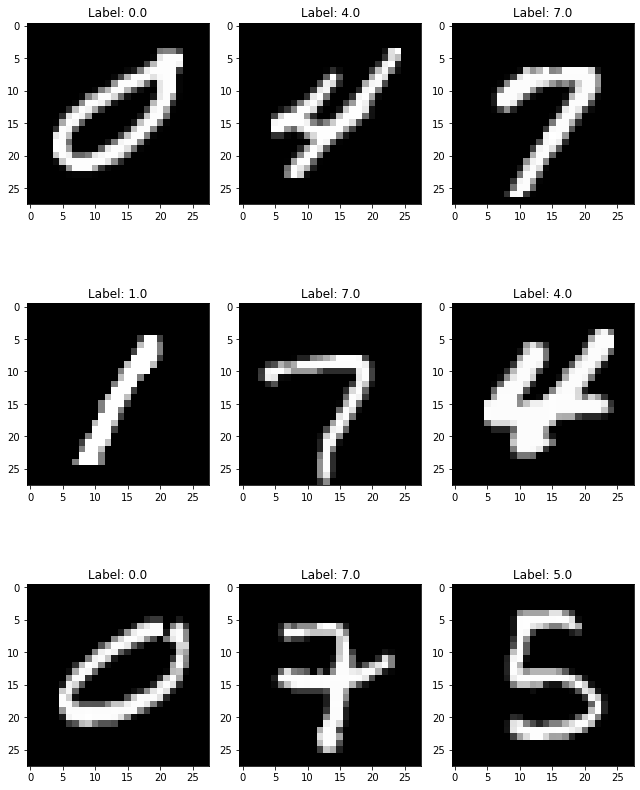

In [ ]:
images, labels = [], []
for i, (data, label) in enumerate(train_data):
  data = data.as_in_context(ctx)
  label = label.as_in_context(ctx)
  images.append(data)
  labels.append(label)
  if i >= 8: break

n_rows = 3
n_columns = 3
num = n_rows * n_columns 

fig, axes = plt.subplots(n_rows, n_columns, figsize=(3.0*n_columns,4*n_rows))
for i in range(num):
  ax = axes[i//n_columns, i%n_columns]
  ax.imshow(images[i][0].asnumpy().reshape(28,28), cmap='gray')
  if fashion:
    ax.set_title('Label: {}'.format(label_desc[labels[i][0].asscalar()] + " (" + str(labels[i][0].asscalar()) +")" ))
  else:
    ax.set_title('Label: {}'.format(labels[i][0].asscalar()))

plt.tight_layout()
plt.show()


## Activation function ReLU (Rectified Linear Unit) and Softplus

As a activation function we will use the ReLU function for the hidden units of our neural network. 
A "Rectified Linear Unit" is an activation function that is often used in Deep Learning models. Basically, the function returns a value of 0 if the input is negative, and if it receives a positive value, the function returns the same positive value. 

The function can be understood as: $f(x)=max(0,x)$ 

The softplus is its differential surrogate and is defined as $f(x) = ln(1+e^{x})$

It is much easier and more efficient to calculate the function ReLU and its derivative than that from the softplus function. The softplus function has the log(.) and exp(.) in its formula. Interestingly, the derivative of the softplus function is the logistic function: $f'(x) = \dfrac{1}{1+e^{-x}}$

In Deep Learning, the computation of the activation function and its derivative is as common as addition and subtraction in arithmetic. By changing to ReLU, the forward and backward passes are much faster, while retaining the non-linear property of the activation function that is required for deep neural networks to be useful.


> #### Advantages of ReLU:
> The advantage of ReLU is the computational efficiency. This allows the network to converge very quickly. Furthermore, it is a non-linear function although it looks like a linear function. ReLU has a derivative function and allows backpropagation.

> #### Disadvantages of ReLU:
> In this case, there is the dying RLU problem, when the inputs go to zero or are negative, the gradient of the function becomes zero, the network cannot perform backpropagation and cannot learn.






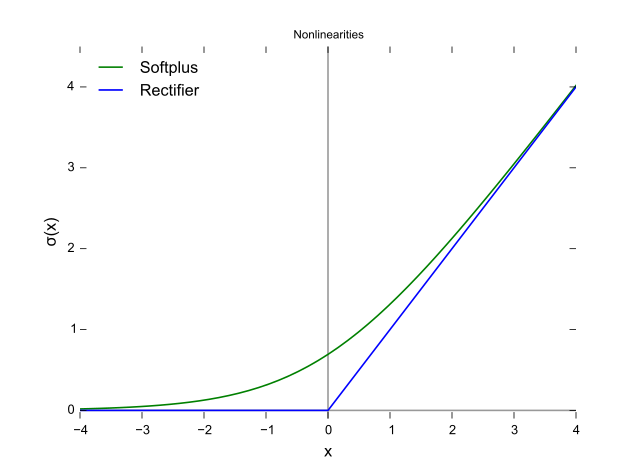



In [ ]:
# defining "standard" ML function, e.g. for layer output functions

# relu for our layer outputs
def relu(X):
  zeros = nd.zeros_like(X)  
  return nd.maximum(X, zeros)

# also we define softplus here, which we don't use for layer putput but for the reparametrization trick later
def softplus(x):
  return nd.log(1 + nd.exp(x))

## **Neural Network Modeling**







In [ ]:
n_hidden_layers = experiments_config['num_hidden_layers']
n_hidden_units = experiments_config['num_hidden_units'] # or 200, 800, 1200 respectively

def feed_forward(X, weights):
  "Computes one pass through the ANN and returns the output layer vector (probabilities)."

  layer_input = X
  num = len(weights) // 2 - 1 
  for i in range(num):
    h_linear = nd.dot(layer_input, weights[2*i]) + weights[2*i + 1]
    layer_input = relu(h_linear)
  # last layer without ReLU
  output = nd.dot(layer_input, weights[-2]) + weights[-1]
  return output

def layer_shapes(n_features: int, n_hidden_units: int, n_hidden_layers: int, n_classes: int) -> list:
  "Returns a list of tuples, which contain the shape of the respective layers."
  
  layer_param_shapes = []
  
  for i in range(n_hidden_layers + 1):
    if i == 0: # input layer
      W_shape = (n_features, n_hidden_units)
      b_shape = (n_hidden_units,)
    elif i == n_hidden_layers: # last layer
      W_shape = (n_hidden_units, n_classes)
      b_shape = (n_classes,)
    else: # hidden layers
      W_shape = (n_hidden_units, n_hidden_units)
      b_shape = (n_hidden_units,)
    
    layer_param_shapes.extend([W_shape, b_shape])
  
  return layer_param_shapes


layer_param_shapes = layer_shapes(n_features, n_hidden_units, n_hidden_layers, n_classes)

In [ ]:
layer_param_shapes

[(784, 400), (400,), (400, 400), (400,), (400, 10), (10,)]

## **Approach of achieving the Bayesian view on the Neural Network**

---

We have here the well-known Bayesian principle $P(w \vert \mathcal{D}) = \dfrac{P(\mathcal{D} \vert w)}{P(\mathcal{D})}$ with the model $w$, data set $\mathcal{D}$, the prior distribution P(w) and the posterior distribution $P(w|\mathcal{D})$. In a Bayesian neural network, the dataset $\mathcal{D}$ consists of $\mathcal{D} = \{x_i, y_i\}$. For such a neural network, a model $f(X \vert w) = Y$ can be chosen so that it is parameterized by the weights $w$. The model will now be trained with the weights $w$ and always adjusted to minimize a loss function $L$. 


For our implementation of the Bayes by Backprop algorithm, we need the Bayesian posterior. The problem here, however, is that the "real" posterior $P(w \vert \mathcal{D})$ will be difficult to determine. However, there are several ways to determine the Bayesian posterior. In the following, we present three different options.




### Option 1: Mathematical calculation:

To write an explicit formula for the posterior, we would have to integrate over all possible weights of the neural network. This procedure is very impractical and the solution is difficult to compute, so we reject this possibility.



### Option 2: Using sampling
In this approach that one could follow is to use sampling from $P(w \vert \mathcal{D})$. This would require taking samples from a distribution with many dimensions, in the number of parameters that are present in the neural network. The problem here is that neural networks often have thousands, if not millions, of parameters. Because of this complexity, this approach is also out of the question for our implementation.
 


### Option 3: Variational Inference
In this option, we approximate each weight $w_i$ with a normal distribution with mean value of $\mu_i$ and standard deviation of $\sigma_i$. 
All these new parameters are described as $\theta = (\mu, \sigma)$. This again defines a distribution over all weights $q(w \vert \theta)$.
	
We can see how this idea is represented in Figure 2. Note that each weight $w_i$ is taken from a normal distribution with mean value of $\mu_i$ and variance value of $\sigma_i$, because it is not possible to simply choose convenient values for $\mu$'s and $\sigma$'s. A distribution $q(w \vert \theta)$ is needed that is "near" the final target $P(w \vert \mathcal{D})$. The concept of "nearness" can be formalized with the Kullback-Leibler divergence, which calculates the distance between two distributions. 
In order to use this option, we need to introduce the definition of Kullback-Leibler divergence first. 

**KL-Divergence**

--- 
We assume a variational posterior distribution on the weights, namely $q(w|\theta)$. With variational learning we want to find the paramters $\theta^\star$ that minimize the Kullback-Leibler (KL) divergence between the variational posterior and the true Bayesian posterior $P(w|\mathcal{D})$. <br>
In general the KL divergence measures the similarity of two probability distributions described by the random variables A and B. It is defined as follows:   <br>
\begin{equation}
KL(A\vert \vert B ) = \sum_{x \in \mathcal{X}} A(x) \cdot \log \left( \frac{A(x)}{B(x)} \right) \;\;\;\; \text{(A, B discrete)} \\
KL(A\vert \vert B ) = \int_{-\infty}^{\infty} A(x) \cdot \log \left( \frac{A(x)}{B(x)} \right) \;\;\;\; \text{(A, B continuous)} \\
\end{equation}
One can obeserve that the KL Divergence again can be expressed in terms of an expected value. Non formally speaking it is the expected value w.r.t to the probability distribtuion A of the log difference of the probabilities A and B. <br>
Note: this is not a classical distance metric as it is not symmetric, i.e $KL(A\vert \vert B ) \neq KL(B\vert \vert A )$ in most of the cases.

In the figure below the process of optimizing the KL Divergence between two probability distribtuions is visualized. $q(w|\theta)$ corresponds to $A_\theta$, $A_{\theta_0}$ and $A_{\theta^\star}$, where the $\theta_0$ depicts the inital values for $\theta$ and $\theta^\star$ the optimized value; $B^\star$ stands for the true Bayesian posterior and the red line depicts the difference bewtween the truth and the optimized posteriors. As we optimize our paramter $\theta$ the assumed distribution $q(w|\theta)$ gets closer and closer to the true posterior distribution.

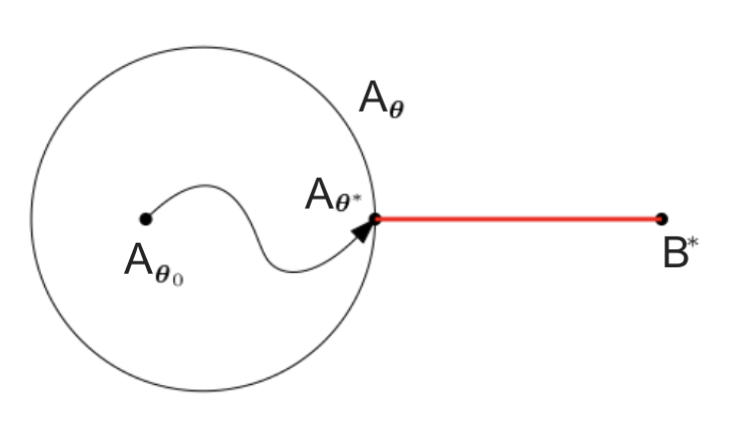

*The picture above is taken from [2]*

The loss function is also transferable to batch training. When performing training with batches the loss function for mini batch $i$ ($i \in \{1,2,...,M\})$becomes the following (as stated in equation (8) in the original paper): <br>
\begin{align*}
  \mathcal{F_{batch_i}}(\mathcal{D_i}, \theta) &= \frac{1}{M} KL[q(w|\theta) || P(w)] - \mathbb{E}_{q(w|\theta)}[\log P(\mathcal{D_i}|w)] \\
  & \approx \frac{1}{M}( \log q(w|\theta) - \log P(w) ) - \log P(\mathcal{D_i} | w)
\end{align*}


So the goal of "Option 3" will be to minimize the KL-divergence between $q(w \vert \theta)$ and $P(w \vert \mathcal{D})$ as much as possible.  Formally, we seek that $\theta^*$ is equal to : 

\begin{equation}
\theta^* = \underset{\theta}{\mathrm{argmin}} \text{ KL}\left[q(w \vert \theta) \vert P(w \vert \mathcal{D})\right]
\end{equation}

### Introducing the likelihood
---
We will use the softmax to define our likelihood $P(\mathcal{D}_𝑖|w)$ function. 


In [ ]:
def log_likelihood(yhat_linear, y):
    softmax = nd.log_softmax(yhat_linear);
    return nd.nansum(y * softmax , axis=0, exclude=True)

## Introducing the loss function
---
Derving the loss function for the Bayesian view on neural neworks ultimately comes to stating the opitimzation problems which finds the optimal parameters $\theta^\star$ of the chosen variational posterior distribution $q(w|\theta)$ that minimize the KL-Divergence bewtween $q(w|\theta)$ and $P(w|\mathcal{D})$.Stated mathematically this means:<br> 
\begin{align*}
\theta^\star &= argmin_{\theta} \; KL[q(w|\theta) || P(w|\mathcal{D})] \\
             &= argmin_{\theta} \; \int q(w|\theta) \log \left( \frac{q(w|\theta)}{P(w)P(\mathcal{D}|w)} \right) \\
             &= argmin_{\theta} \; \underbrace{\underbrace{KL[q(w|\theta) || P(w)]}_{\text{complexity cost}} - \underbrace{\mathbb{E}_{q(w|\theta)}[\log P(\mathcal{D}|w)]}_{\text{likelihood cost}}}_{\mathcal{F}(\mathcal{D}, \theta)}
\end{align*}
<br>
The expression to minimize is commonly known as the variational free energy and consists of a *complexity cost*, which does not depend on the data and a *likelihood cost*, which depends on the data.
<br>
The expression to minimize then becomes the loss function for Bayes by Backprop and is given by equations (1,2) in the original paper [1]. <br>
\begin{align}
\mathcal{F}(\mathcal{D}, \theta) & = KL[q(w|\theta) || P(w)] - \mathbb{E}_{q(w|\theta)}[\log P(\mathcal{D}|w)] \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; (1)\\
\mathcal{F}(\mathcal{D}, \theta) &\approx \sum_{i=1}^n \log q(w^{(i)}|\theta) - \log P(w^{(i)}) - \log P(\mathcal{D} | w^{(i)}) \;\;\;\;\;\;\;\;\;\;\;\;\; (2)
\end{align}
The 
<br>
These equations stem from finding the paramters $\theta^\star$ that minimize the Kullback-Leibler (KL) divergence between the posterior $q(w|\theta)$ and the true (bayesian) posterior on the weights. (1) Since acutally computing the closed form loss functions minimums is computationally intractable an approximation via Monte Carlo sampling is considered. This estimating of (1) via Monte-Carlo sampling yields (2). <br>
<br>
(Note: the first term (complexitiy cost) in $\mathcal{F}(\mathcal{D}, \theta)$ can be expressed as expectations w.r.t $q(w \vert \theta)$ and thus we obtain the three expectations we approximate via (2))


### Introducing the prior 
---
For each weight $w_i$ in the neural network, we assume it to be sampled from a certain probability distribution. This is a design choice and should come close to the original weights distribution. In the original paper a scale mixture or gaussian prior have prooved to be reliable, so we will stick to the latter for now.

We will use a simple gaussian prior, i.e. we assume the weights $w_i$ to be distributed with $w_i \sim \mathcal{N}(\mu_i, \sigma_i^2)$. Also assuming these weights to be independently generated, we can describe the probability of the whole weight vector as: <br>
\begin{equation} 
P(w) = \prod_i p(w_i) = \prod_i \left[ \frac{1}{\sigma_i \sqrt{2 \pi}}exp\left(- \frac{1}{2}\left(\frac{x-\mu_i}{\sigma_i}\right)^2 \right) \right]
\end{equation}
Taking the log and using log rules to split the log of a product into a sum of logs yields: <br>
\begin{equation}
\log P(w) = \log \big( \prod_i (p(w_i) \big) = \sum_i \log p(w_i)
\end{equation}

The $\log p(w_i)$ that is used in the code below is derived as follows:

\begin{align*}
  \log p(w_i) &= \log \left[ \frac{1}{\sigma_i \sqrt{2 \pi}}exp\left(- \frac{1}{2}\left(\frac{x-\mu_i}{\sigma_i}\right)^2 \right) \right] \\
  & = \log \left( \frac{1}{\sigma_i (2 \pi)^{0.5} } \right) - \frac{(x-\mu)^2}{2\sigma_i^2} \\
  &= \log1 - \log \sigma_i - 0.5 \log(2\pi) - \frac{(x-\mu)^2}{2\sigma_i^2} \\
  &= -0.5 \log(2\pi) - \log \sigma_i - \frac{(x-\mu)^2}{2\sigma_i^2} 
\end{align*}

Essentially, as can be seen in the code below, we centered the gaussians around the same mean, that is $\mu_i = 0, \; \forall i \in \{1,...,N\}$. <br>
Furthermore we set all the sigmas to be 1, that is, $\sigma_i = 1, \; \forall i \in \{1,...,N\}$. <br>
With that configuration we obtain the *standard normal distribution* to sample the weights from. 

In [ ]:
def log_gaussian(x, mu, sigma):
  return -0.5 * np.log(2.0 * np.pi) - nd.log(sigma) - ((x - mu) ** 2 / (2 * (sigma ** 2)))

def sum_log_gaussian(x):
  mu = experiments_config['mu_prior']
  sigma = nd.array([experiments_config['sigma_prior']], ctx=ctx) # for nd.log in "log_gaussian(x, mu, sigma)" we need an array (not just a double, ...)

  return nd.sum(log_gaussian(x, mu, sigma))

## **Showing the reparametrization trick and stating design choices**
--- 


The loss function is also transferable to batch training. When performing training with batches the loss function for mini batch $i$ ($i \in \{1,2,...,M\})$becomes the following (as stated in equation (8) in the original paper): <br>
\begin{align*}
  \mathcal{F_{batch_i}}(\mathcal{D_i}, \theta) &= \frac{1}{M} KL[q(w|\theta) || P(w)] - \mathbb{E}_{q(w|\theta)}[\log P(\mathcal{D_i}|w)] \\
  & \approx \frac{1}{M}( \log q(w|\theta) - \log P(w) ) - \log P(\mathcal{D_i} | w)
\end{align*}


In [ ]:
# calculate data likelihood
def log_likelihood_sum(output, label_one_hot):
  return nd.sum(log_likelihood(output, label_one_hot))

# calculate prior
def log_prior_sum(log_prior, params):
  return sum([nd.sum(log_prior(param)) for param in params])

# calculate cariational posterior
def log_var_posterior_sum(params, mus, sigmas):
  return sum([nd.sum(log_gaussian(params[i], mus[i], sigmas[i])) for i in range(len(params))])

In [ ]:
def total_loss(output, label_one_hot, params, mus, sigmas, log_prior, log_likelihood, n_batches):
  
  ll_sum = log_likelihood_sum(output, label_one_hot)
  lp_sum = log_prior_sum(log_prior, params)
  lvp_sum = log_var_posterior_sum(params, mus, sigmas)
  
  if n_batches == None:
    return (lvp_sum - lp_sum) - ll_sum
  else:
    return 1.0 / n_batches * (lvp_sum - lp_sum) - ll_sum

### The reparametrization trick
---

To finalize the Bayes by Backprop procedure we need one more trick: the reparametrization. Cited from the paper it loosely means that "*under certain conditions the derivative of an expectation can be expressed as the expectation of a derivative*".
The conditions to be met are the follwoing: 


*   a random variable $\epsilon$ with PDF $q(\epsilon)$
*   the weights defined via a determinsitc function, i.e. $w = t(\theta, \epsilon)$, $t$ deterministic
*   choose the marginal probability denstioy $q(w \vert \theta)$ of w such that $q(\epsilon)d\epsilon = q(w \vert \theta)dw$

Then one can show the following: 
\begin{align*}
\frac{\partial}{\partial \theta}\mathbb{E}_{q(w \vert \theta)}[f(w, \theta)] &= \frac{\partial}{\partial \theta} \int f(w, \theta) q(w \vert \theta)dw \\
&= \frac{\partial}{\partial \theta} \int f(w, \theta) q(\epsilon)d\epsilon \\
&= \mathbb{E}_{q(w \vert \theta)} \left[ \frac{\partial f(w,\theta)}{dw} \frac{dw}{d \theta} + \frac{\partial f(w,\theta)}{\partial \theta}\right]
\end{align*}
This means that we can find the derivate of the expected value of $f$ by the expected value of the derivatives of $f$ when setting $f := \log q(w \vert \theta) - \log P(w)P(\mathcal{D}\vert w)$.


### Design Choices
---

After having introduced all these theoretical concepts and in some case reexpressing the in order to efficiently state them within a programming language we want to give a quick summary with which configuration we have conducted our experiments of the Bayes by Backprop method.


*   prior over the weights: $P(w) \sim \mathcal{N}(\mu_p, \sigma_p^2)$
*   variational posterior: $q(w \vert \theta) \sim \mathcal{N}(\mu, \sigma^2)$
*   make $\sigma$ positive via sofplus, i.e. $\sigma = \log(1 + \exp(\rho))$
*   introduce parameter free $\epsilon \sim \mathcal{N}(0,I)$
*   deterministic function $w = t(\theta, \epsilon) = \mu + \sigma \circ \epsilon$
<br>

There are some design choices that can be made here, for instance in the original paper a weight prior of a scale mixture gaussian was chosen as well and proved to give significantly better results than other configurations.


## **Training the Bayesian Neural Network**
---

Below we define two utility functions. The first will perform the stochastic gradient descent (SGD) on the variational parameters intended to optimize. Furthermore space is allocated for the automatic gradient software to store the computations found when performing SGD. <br>
The latter evaluates the accuracy of the model, i.e it passes one input (a batch of inputs) through the artificial neural network (ANN) and computes the fraction of correctly classified inputs to the totally classified inputs. <br> 
Lastly the variational parameters are initialized. $\rho$ is initialized at -3 and $\mu$ randomly nintialized from a normal distribution. 

In [ ]:
# stochastic gradient descent
def SGD(params, alpha):
  for param in params:
    param[:] = param - alpha * param.grad

In [ ]:
# evaluation metric: correctly classified / total classified
def eval_accuracy(data_iter, feed_forward, layer_params):
  numerator, denominator = 0, 0
  for i, (data, label) in enumerate(data_iter):
    data = data.as_in_context(ctx).reshape((-1, 784)) 
    label = label.as_in_context(ctx)
    output = feed_forward(data, layer_params)
    predictions = nd.argmax(output, axis=1)
    numerator += nd.sum(predictions == label)
    denominator += data.shape[0]

  return (numerator/denominator).asscalar()


In [ ]:
# initialize variational parameters, mean and variance for each weight distribution
mus = []
rhos = []
weight_scale = .1
rho_offset = -3

for shape in layer_param_shapes:
  mu = nd.random_normal(shape=shape, ctx=ctx, scale=weight_scale)
  rho = rho_offset + nd.zeros(shape=shape, ctx=ctx)
  mus.append(mu)
  rhos.append(rho)

variational_params = mus + rhos

# allocate space for gradient descent calculations
for variational_param in variational_params:
  variational_param.attach_grad()

### The Bayes by Backprop Algorithm in a Nutshell
---

The basic algorithm can be divided into six steps (additional typical ANN computations like forward propagation are implicit):


1.   Sample $\epsilon \sim \mathcal{N}(0, I)$
2.   Let $w = \mu + \log(1+exp(\rho)) \circ \epsilon$ (and let $\theta = (\mu, \rho)$)
4.   Let $f(w,\theta) = \log q(w|\theta) - \log P(w) P(\mathcal{D}|w)$
5.   Calculate the gradient with respect to $\mu$ / the mean <br>
      * $\nabla_\mu = \frac{\partial f(w,\theta)}{\partial w} + \frac{\partial f(w,\theta)}{\partial \mu}$
6.   Calculate the gradient with respect to $\rho$ / the standard deviation <br>
      * $\nabla_\rho = \frac{\partial f(w,\theta)}{\partial w}\frac{\epsilon}{1+exp(-\rho)} + \frac{\partial f(w,\theta)}{\partial \rho}$
7.   Update the variational parameters: <br> 
     * $\mu \longleftarrow \mu - \alpha \nabla_\mu$
     * $\rho \longleftarrow \rho - \alpha \nabla_\rho$
<br>

In the following code block the main steps are highlighted according to the step numbers defined above they belong to. (the rest of the steps are found in the main training loop.)




In [ ]:
# 1. sample epsilon from standard normal 
def sample_epsilons(param_shapes):
  return [nd.random_normal(shape=shape, loc=0., scale=1.0, ctx=ctx) for shape in param_shapes]

# parameterise the standard deviation pointwise as sigma = log(1+exp(rho)), so sigma is non-negative
def compute_sigmas(rhos):
  return [softplus(rho) for rho in rhos]

# 2. compute w: w = mu + sigma * epsilon; this is the reparametrization trick
def compute_weights(mus, sigmas, epsilons):
  return [ mus[i] + sigmas[i] * epsilons[i] for i in range(len(mus)) ]

### Main Training Loop
---

In [ ]:
# complete loop
n_epochs = experiments_config['epochs'] #50 # experiments_config['max_epochs'] # experiments_config['epochs']
alpha = experiments_config['alpha']
smoothing_constant = .01
train_acc, test_acc = [], []

# 6. repeat the training process for the specified number of epochs
for epoch in tqdm(range(n_epochs)):
  for i, (data, label) in enumerate(train_data):
    # extract the data in the needed shape and convert labels to one-hot-vectors
    data = data.as_in_context(ctx).reshape((-1,784))
    label = label.as_in_context(ctx)
    label_one_hot = nd.one_hot(label, 10)

    with autograd.record():
      # 1. sample epsilon ~ N(0,I)
      epsilons = sample_epsilons(layer_param_shapes)

      # make sigmas positive, i.e. sigma = log(1 + exp(rho)) = softplus(rho)
      sigmas = compute_sigmas(rhos)

      # 2. w = mu + sigma * epsilon --> obtain a sample from q(w|theta) by transforming the epsilons
      weights = compute_weights(mus, sigmas, epsilons)

      # forward propagate the batch
      output = feed_forward(data, weights)

      # 3. compute loss, i.e. L = log q(w|theta) - log P(w) - log P(D|w)
      loss = total_loss(output, label_one_hot, weights, mus, sigmas, sum_log_gaussian, log_likelihood, n_batches)

    # 4.+ 5. compute the loss gradients w.r.t. the parameters mu, rho
    loss.backward()

    # 6. apply SGD to variational parameters, contains updating the variational parameters
    SGD(variational_params, alpha)

    # compute moving loss for monitoring convergence
    curr_loss = nd.mean(loss).asscalar()
    moving_loss = (curr_loss if (i==0) and (epoch==0)
                   else (1-smoothing_constant) * moving_loss +  smoothing_constant * curr_loss)
    
  test_acc = eval_accuracy(test_data, feed_forward, mus)
  train_acc = eval_accuracy(train_data, feed_forward, mus)
  print("Epoch %s/%s. Loss: %s, Train_acc: %s, Test_acc: %s" %(epoch, n_epochs, round(moving_loss,2), round(train_acc,4), round(test_acc,4)))
    

  2%|▏         | 1/50 [01:52<1:32:06, 112.79s/it]

Epoch 0/50. Loss: 2629.66, Train_acc: 0.9399, Test_acc: 0.937


  4%|▍         | 2/50 [03:46<1:30:20, 112.93s/it]

Epoch 1/50. Loss: 2608.09, Train_acc: 0.9638, Test_acc: 0.9574


  6%|▌         | 3/50 [05:38<1:28:25, 112.89s/it]

Epoch 2/50. Loss: 2600.56, Train_acc: 0.9712, Test_acc: 0.9662


  8%|▊         | 4/50 [07:31<1:26:33, 112.91s/it]

Epoch 3/50. Loss: 2597.29, Train_acc: 0.9756, Test_acc: 0.9677


 10%|█         | 5/50 [09:24<1:24:38, 112.85s/it]

Epoch 4/50. Loss: 2593.36, Train_acc: 0.9792, Test_acc: 0.9722


 12%|█▏        | 6/50 [11:18<1:22:54, 113.06s/it]

Epoch 5/50. Loss: 2591.2, Train_acc: 0.9816, Test_acc: 0.9743


 14%|█▍        | 7/50 [13:11<1:21:09, 113.25s/it]

Epoch 6/50. Loss: 2588.62, Train_acc: 0.9838, Test_acc: 0.9762


 16%|█▌        | 8/50 [15:04<1:19:14, 113.20s/it]

Epoch 7/50. Loss: 2586.34, Train_acc: 0.9856, Test_acc: 0.976


 18%|█▊        | 9/50 [16:58<1:17:23, 113.25s/it]

Epoch 8/50. Loss: 2584.57, Train_acc: 0.9874, Test_acc: 0.9774


 20%|██        | 10/50 [18:51<1:15:30, 113.26s/it]

Epoch 9/50. Loss: 2582.14, Train_acc: 0.9878, Test_acc: 0.9774


 22%|██▏       | 11/50 [20:43<1:13:27, 113.00s/it]

Epoch 10/50. Loss: 2581.32, Train_acc: 0.9884, Test_acc: 0.9777


 24%|██▍       | 12/50 [22:35<1:11:22, 112.71s/it]

Epoch 11/50. Loss: 2579.8, Train_acc: 0.9907, Test_acc: 0.979


 26%|██▌       | 13/50 [24:27<1:09:18, 112.38s/it]

Epoch 12/50. Loss: 2578.38, Train_acc: 0.992, Test_acc: 0.9792


 28%|██▊       | 14/50 [26:18<1:07:14, 112.07s/it]

Epoch 13/50. Loss: 2576.62, Train_acc: 0.9924, Test_acc: 0.9802


 30%|███       | 15/50 [28:10<1:05:17, 111.92s/it]

Epoch 14/50. Loss: 2575.42, Train_acc: 0.9927, Test_acc: 0.9791


 32%|███▏      | 16/50 [30:01<1:03:15, 111.63s/it]

Epoch 15/50. Loss: 2573.84, Train_acc: 0.9938, Test_acc: 0.9795


 34%|███▍      | 17/50 [31:52<1:01:18, 111.47s/it]

Epoch 16/50. Loss: 2571.96, Train_acc: 0.9938, Test_acc: 0.9798


 36%|███▌      | 18/50 [33:45<59:39, 111.86s/it]  

Epoch 17/50. Loss: 2570.78, Train_acc: 0.9944, Test_acc: 0.9795


 38%|███▊      | 19/50 [35:36<57:39, 111.59s/it]

Epoch 18/50. Loss: 2569.67, Train_acc: 0.9953, Test_acc: 0.9823


 40%|████      | 20/50 [37:27<55:46, 111.55s/it]

Epoch 19/50. Loss: 2568.84, Train_acc: 0.9956, Test_acc: 0.9805


 42%|████▏     | 21/50 [39:18<53:52, 111.45s/it]

Epoch 20/50. Loss: 2567.22, Train_acc: 0.9962, Test_acc: 0.981


 44%|████▍     | 22/50 [41:10<52:00, 111.45s/it]

Epoch 21/50. Loss: 2565.91, Train_acc: 0.9963, Test_acc: 0.9812


 46%|████▌     | 23/50 [43:01<50:03, 111.24s/it]

Epoch 22/50. Loss: 2565.12, Train_acc: 0.9966, Test_acc: 0.9805


 48%|████▊     | 24/50 [44:52<48:11, 111.21s/it]

Epoch 23/50. Loss: 2563.49, Train_acc: 0.9973, Test_acc: 0.9814


 50%|█████     | 25/50 [46:43<46:17, 111.12s/it]

Epoch 24/50. Loss: 2562.33, Train_acc: 0.9975, Test_acc: 0.9815


 52%|█████▏    | 26/50 [48:35<44:32, 111.35s/it]

Epoch 25/50. Loss: 2561.09, Train_acc: 0.9978, Test_acc: 0.9816


 54%|█████▍    | 27/50 [50:26<42:40, 111.32s/it]

Epoch 26/50. Loss: 2560.08, Train_acc: 0.9978, Test_acc: 0.9807


 56%|█████▌    | 28/50 [52:18<40:54, 111.55s/it]

Epoch 27/50. Loss: 2558.67, Train_acc: 0.9981, Test_acc: 0.9828


 58%|█████▊    | 29/50 [54:10<39:03, 111.59s/it]

Epoch 28/50. Loss: 2558.04, Train_acc: 0.9982, Test_acc: 0.9818


 60%|██████    | 30/50 [56:01<37:12, 111.61s/it]

Epoch 29/50. Loss: 2556.79, Train_acc: 0.9979, Test_acc: 0.9809


 62%|██████▏   | 31/50 [57:52<35:18, 111.49s/it]

Epoch 30/50. Loss: 2555.29, Train_acc: 0.9986, Test_acc: 0.9827


 64%|██████▍   | 32/50 [59:43<33:23, 111.32s/it]

Epoch 31/50. Loss: 2554.47, Train_acc: 0.9985, Test_acc: 0.9816


 66%|██████▌   | 33/50 [1:01:34<31:30, 111.18s/it]

Epoch 32/50. Loss: 2552.9, Train_acc: 0.9987, Test_acc: 0.9821


 68%|██████▊   | 34/50 [1:03:26<29:40, 111.25s/it]

Epoch 33/50. Loss: 2552.03, Train_acc: 0.9989, Test_acc: 0.9816


 70%|███████   | 35/50 [1:05:17<27:50, 111.35s/it]

Epoch 34/50. Loss: 2551.47, Train_acc: 0.9988, Test_acc: 0.9826


 72%|███████▏  | 36/50 [1:07:09<26:02, 111.59s/it]

Epoch 35/50. Loss: 2550.09, Train_acc: 0.9989, Test_acc: 0.9825


 74%|███████▍  | 37/50 [1:09:01<24:12, 111.71s/it]

Epoch 36/50. Loss: 2549.43, Train_acc: 0.999, Test_acc: 0.9822


 76%|███████▌  | 38/50 [1:10:53<22:20, 111.67s/it]

Epoch 37/50. Loss: 2547.76, Train_acc: 0.9992, Test_acc: 0.9829


 78%|███████▊  | 39/50 [1:12:44<20:26, 111.53s/it]

Epoch 38/50. Loss: 2546.99, Train_acc: 0.9993, Test_acc: 0.9832


 80%|████████  | 40/50 [1:14:35<18:34, 111.47s/it]

Epoch 39/50. Loss: 2545.7, Train_acc: 0.9992, Test_acc: 0.9821


 82%|████████▏ | 41/50 [1:16:27<16:44, 111.57s/it]

Epoch 40/50. Loss: 2544.71, Train_acc: 0.9993, Test_acc: 0.9823


 84%|████████▍ | 42/50 [1:18:20<14:54, 111.87s/it]

Epoch 41/50. Loss: 2543.06, Train_acc: 0.9994, Test_acc: 0.983


 86%|████████▌ | 43/50 [1:20:11<13:01, 111.69s/it]

Epoch 42/50. Loss: 2542.67, Train_acc: 0.9993, Test_acc: 0.9822


 88%|████████▊ | 44/50 [1:22:03<11:09, 111.66s/it]

Epoch 43/50. Loss: 2541.49, Train_acc: 0.9994, Test_acc: 0.9829


 90%|█████████ | 45/50 [1:23:54<09:17, 111.45s/it]

Epoch 44/50. Loss: 2540.13, Train_acc: 0.9995, Test_acc: 0.9821


 92%|█████████▏| 46/50 [1:25:44<07:24, 111.15s/it]

Epoch 45/50. Loss: 2539.36, Train_acc: 0.9996, Test_acc: 0.9834


 94%|█████████▍| 47/50 [1:27:35<05:33, 111.06s/it]

Epoch 46/50. Loss: 2538.19, Train_acc: 0.9995, Test_acc: 0.9829


 96%|█████████▌| 48/50 [1:29:29<03:43, 111.83s/it]

Epoch 47/50. Loss: 2537.05, Train_acc: 0.9997, Test_acc: 0.9828


 98%|█████████▊| 49/50 [1:31:19<01:51, 111.50s/it]

Epoch 48/50. Loss: 2535.92, Train_acc: 0.9997, Test_acc: 0.9829


100%|██████████| 50/50 [1:33:11<00:00, 111.83s/it]

Epoch 49/50. Loss: 2535.13, Train_acc: 0.9997, Test_acc: 0.9826


### Obtaining results for Vanilla SGD and Dropout ANNs 
(according to figure 3 in the original paper) <br>
For quickness and easyness of setup here we decided to use the Keras API to deploy some ASAP experimental setup and thus data collection.
Note that we also used slightly lower number of epochs (50 or 100) to generate the trend of weights distributions to be viusalized for all three of the experiments.

In [ ]:
!pip install mnist

In [ ]:
import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

Loading the data for the keras API

In [ ]:
# loading the images
X_train, y_train = mnist.train_images(), mnist.train_labels()
X_test, y_test = mnist.test_images(), mnist.test_labels()

In [ ]:
# transforming the data as in the original paper / done by the transform function above, i.e. dividing pixels by 126.0
X_train, X_test = X_train / 126.0, X_test / 126.0

# flatten the pixel array to be "fed" into the neural networks
X_train, X_test = X_train.reshape((-1, 784)), X_test.reshape((-1, 784))

# make the single digit labels one-hot vectors
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Vanilla SGD model

In [ ]:
modelVanillaSGD = Sequential([
  Dense(400, activation='relu', input_shape=(784,)),
  Dense(400, activation='relu'),
  Dense(10, activation='softplus'),
])

modelVanillaSGD.compile(optimizer=Adam(lr=experiments_config["alpha"]), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
historyVanillaSGD = modelVanillaSGD.fit(X_train, y_train, epochs=experiments_config['epochs'], batch_size=experiments_config["batch_size"])

In [ ]:
modelVanillaSGD.evaluate(X_test, y_test, batch_size=experiments_config["batch_size"])

79/79 [==============================] - 0s 3ms/step - loss: 0.1311 - categorical_accuracy: 0.9826


[0.13106343150138855, 0.9825999736785889]

Dropout model

In [ ]:
modelDropout = Sequential([
  Dense(400, activation='relu', input_shape=(784,)),
  Dropout(0.5),
  Dense(400, activation='relu'),
  Dropout(0.5),
  Dense(10, activation='softplus'),
])

modelDropout.compile(optimizer=Adam(lr=experiments_config["alpha"]), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
historyDropout = modelDropout.fit(X_train, y_train, epochs=experiments_config['epochs'], batch_size=experiments_config["batch_size"])

In [ ]:
modelDropout.evaluate(X_test, y_test, batch_size=experiments_config["batch_size"])

79/79 [==============================] - 0s 3ms/step - loss: 0.0771 - categorical_accuracy: 0.9849


[0.07710646092891693, 0.9848999977111816]

### Plotting the density histograms for the weight distributions. 
For each of the three setups we plot the weights as they are after the final training iteration. <br>
For the Bayes by Backprop algortihm this means the weights vector, i.e. the shifted and reparametrized samples.


In [ ]:
# functions for flattening out the weights values, 

def flatten_weights(weights):
  w_flattened = []
  for i in range(len(weights)):
    for j in range(len(weights[i])):
      for k in range(len(weights[i][j])):
        w_flattened.append(weights[i][j][k].asscalar())
  
  return w_flattened

def flatten_SGD_weights(model, with_bias: bool=True):
  w_flattened = []
  for i in range(3):
    #print("Layer", i, " shape:", model.layers[i].get_weights()[0].shape)
    layer_weights = model.layers[i].get_weights()[0]
    layer_biases = model.layers[i].get_weights()[1]
    
    # add normal weights
    for j in range(layer_weights.shape[0]):
      for k in range(layer_weights.shape[1]):
        w_flattened.append(layer_weights[j][k])
    
    # add bias weights
    if with_bias:
      for j in range(layer_biases.shape[0]):
          w_flattened.append(layer_biases[j])

  return w_flattened

def flatten_dropout_weights(model, with_bias: bool=True):
  w_flattened = []
  for i in range(5):
    #print("Layer", i)
    if (i == 0 or i == 2 or i == 4 ):
      layer_weights = model.layers[i].get_weights()[0]
      layer_biases = model.layers[i].get_weights()[1]
      
      # add normal weights
      for j in range(layer_weights.shape[0]):
        for k in range(layer_weights.shape[1]):
          w_flattened.append(layer_weights[j][k])
      
      # add bias weights
      if with_bias:
        for j in range(layer_biases.shape[0]):
          w_flattened.append(layer_biases[j])

  return w_flattened

In [ ]:
w_flat = flatten_weights(weights) # flatten of the last sample of q(w|theta) in the last epoch of training

In [ ]:
SGD_w_flat = flatten_SGD_weights(modelVanillaSGD, True) 
dropout_w_flat = flatten_dropout_weights(modelDropout, True)

In [ ]:
# len(w_flat), len(SGD_w_flat), len(dropout_w_flat)

(478410, 478410, 478410)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

Text(0, 0.5, 'Density')

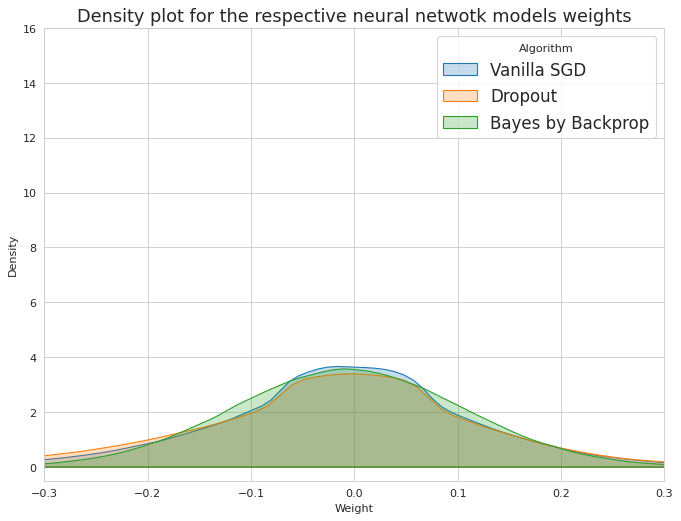

In [ ]:
model_weights = {"Vanilla SGD": SGD_w_flat, "Dropout":dropout_w_flat, "Bayes by Backprop": w_flat}

plt.figure(figsize=(10, 7.5), dpi=80)
sns.set_style("whitegrid")

for model_name, values in model_weights.items():

  sns.distplot(values, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label=model_name)

plt.legend(prop={'size': 15}, title = 'Algorithm')
plt.title('Density plot for the respective neural netwotk models weights', fontsize=16)
plt.xlabel('Weight')
plt.ylim(ymax = 16, ymin = -0.5)
plt.xlim(xmax = 0.3, xmin = -0.3)
plt.ylabel('Density')

## **Results**
---

The results we achieved when training for 10 epochs are summarized in the table below. For the Handwritten Digits MNIST dataset the trend of not improving when adding more units per layer was achieved likewise. However the best result our experiments revealed is a test error of about 0.5% higher than the best result in the original paper. As stated in the paper (and also as fedback when giving the presentation to this notebook) it was remarked that Bayes by Backprop in the original experiment converged at aorund 600 epochs. Hence we rerun the experiment for 600 epochs with 400 units / hidden layer (best model for Gaussian prior in the original paper). Unfortunately after training for 228 epochs (~7 hours) our machine and the google colab server lost connection for an unknown reason and training was cancelled. Still the test error was improved significantly by about 0.5% and even surpassed the original results for the gaussian prior by about 0.2%.<br> 


Adittionally we run the algorithm on the FashionMNIST dataset, were typical state of the art accuracy lies between 90-95% [13] and recent work has even fine-tuned this to a test error of just 3.09% (96.91% accuracy) [12] Here clearly the obtained results are far below, however this may be largely due to the fact that the models performing particularly well on FashionMNIST are extended Neural Networks, for example Convolutional-ANNs.

|     Dataset            | #Units/Layer| Test Error | Original Results |
|------------------------|------------:|-----------:|-----------------:|
| Handwritten            | 200         | 2.51%      | -                |
| Digits                 | 400         | 2.33%      | **1.82%**        |
| MNIST                  | 800         | 2.16%      | 1.99%            |
|                        | 1200        | 2.76%      | 2.04%            |
| (228 epochs re-run)    | 400         | **1.63%**  | -                |
|------------------------|-------------|------------|------------------|
| Fashion                | 200         | **12.63%** | -                |
| MNIST                  | 400         | 13.2%      | -                |
|                        | 800         | 12.81%     | -                |

After adjusting the algorithm, we ran the experiment again for the Vanilla SGD, Dropout, and Bayes By Backprop algorithms. We summarized the results in the plot "Density plot for the respective neural netwotk models weights". In the plot we see the histogram of the trained neural network weights, for Dropout, Vanilla SGD and Bayes By Backprop. To generate the trend of the weight distributions to be virsualized for all three experiments, 50 epochs are used. We can see from the plot that the distribution of Bayes by Backprop weights is the same as presented in the paper "Weight Uncertainty in Neural Networks". An interesting fact is that the results of Dropout and Vanilla SGD are similar to Bayes by Backprop. The fact that the results of the three experiments look similar could be due to the small number of epochs. We can see on the plot that the density of Bayes by Backprop is slightly higher at the -0.1 and 0.1 points than Dropout and SGD. It is possible that the results would look different if we ran a higher number of epochs than 50 for the experiment.

As a note on reproducability we want to say that the paper "Weight Uncertaintanty in Nerual Networks" was structured well and introduced theoretical concepts and design decisions in a descent manner. Parameter choices and results are presented transparently. Some minor impovements we could think of would be a more detailed insight on hyperparameter tuning (e.g. initialzing the variational parameters, which learning rate gave best results, ...) and an open-source implementation for exact comparism of the appoaches of the original authors. 

## **Conclusion**
---

We have gained an impression of an efficient Bayesian approach for neural networks using variational inference via the "Bayes by Backprop" algorithm (introduced by the paper "Weight Uncertainty in Neural Networks"). We implemented and optimized a stochastic version of the variational lower bound to approximate the posterior distribution over the weights of a neural network on the MNIST dataset. The result is that we can achieve regularization on the parameters of the network and accurately quantify the uncertainty over the weights. In conclusion, we have seen that it is possible to significantly reduce the number of weights in the neural network after training while maintaining high accuracy on the test set. 
<br>

We also found that with this model implementation, we could almost reproduce the results of the paper on the MNIST dataset. In the process, we were able to achieve comparable test accuracy for all documented instances of the MNIST classification problem.

### Future directions
Taking a Bayesian view on the weights of neural networks gives valuable insight in the decision making process of artificial neural networks. <br>
The field of *explainable AI* (XAI) has come to more prominence in the recent years. This means that understanding machine learning models, which presumably do good on a certain task, should be examined, trying to understand the core dependencies and thus metaphorically speaking opening the block box model. This leaves room for interpretation and adjustments and could ultimately yield better and / or safer results. <br>
Such research has for example lately been done, when the group of Müller et. al. at TU Berlin found out that seemingly confident image classification models were heavily relying on resource tags on the picture, which contained the name of the classified object. [5] <br>
With industry, entertainment, medical and other sectors relying more and more on ML solutions, it is of particular importance to better understand these models, i.e. making AI more explainable. This especially includes users not familiar with the underlying mathematical concepts. To incorporate the uncertainty of Bayesian Neural Networks into these technologies one could image defning a threshold on a decision such that a models action will only take place if the uncertainty is below this threshold. This could be especially important for safety critical applications, e.g. the medical sector or the automobile industry.

## References
---



[1]   Blundell, Charles, et al. "Weight uncertainty in neural networks." arXiv preprint arXiv:1505.05424 (2015) <br>
[2] Deisenroth, Marc Peter, A. Aldo Faisal, and Cheng Soon Ong. Mathematics for machine learning. Cambridge University Press, 2020  
[3] Chollet, Francois. Deep learning with Python. Vol. 361. New York: Manning, 2018. <br>
[4] Lapuschkin, Sebastian, et al. "Unmasking clever hans predictors and assessing what machines really learn." Nature communications 10.1 (2019): 1-8. <br>
[5] https://joshfeldman.net/WeightUncertainty/ <br>
[6] https://matthewmcateer.me/blog/a-quick-intro-to-bayesian-neural-networks/ <br>
[7] https://github.com/cpark321/uncertainty-deep-learning/blob/master/01.%20Bayes-by-Backprop.ipynb <br>
[8] https://gluon.mxnet.io/chapter18_variational-methods-and-uncertainty/bayes-by-backprop.html <br>
[9] https://www.nitarshan.com/bayes-by-backprop/ <br>
[10] https://mxnet.apache.org/versions/1.7.0/api/python/docs/tutorials/packages/gluon/data/datasets.html <br>
[11] https://medium.com/the-data-science-publication/how-to-import-and-display-the-fashion-mnist-dataset-using-tensorflow-e72522f684d0 <br>
[12] Tanveer, Muhammad Suhaib, Muhammad Umar Karim Khan, and Chong-Min Kyung. "Fine-Tuning DARTS for Image Classification." arXiv preprint arXiv:2006.09042 (2020). <br>
[13] https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-fashion-mnist-clothing-classification/ <br>
